In [2]:
from psychopy import visual, event, core
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw, ImageFont
from numpy.fft import fft2, ifft2, fftshift, ifftshift

In [3]:
# Letter Stimulus 
def ShowImage(image):
    plt.imshow(image, cmap='gray', vmin=0, vmax=1)
    plt.axis('off') 
    plt.show()

def LetterImage(letter, image_size = 128, letter_size = 64, bg_color = 0, letter_color = 1):
    image = Image.new('L', (image_size, image_size), color=bg_color)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("DejaVuSans-Bold.ttf", letter_size)
    bbox = draw.textbbox((0, 0), letter, font = font)
    letter_w, letter_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    image_w, image_h = image.size
    x = (image_w - letter_w) // 2 - bbox[0]
    y = (image_h - letter_h) // 2 - bbox[1]
    draw.text((x, y), letter, font = font, fill=letter_color)
    return np.array(image).astype(np.float32)

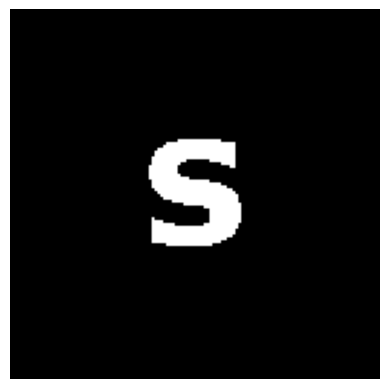

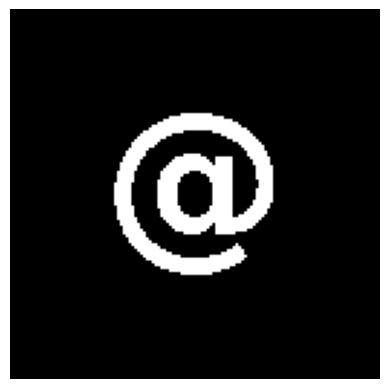

In [6]:
ShowImage(LetterImage(letter = 's'))
ShowImage(LetterImage(letter = '@'))

3086.3551 	WARNING 	Monitor specification not found. Creating a temporary one...


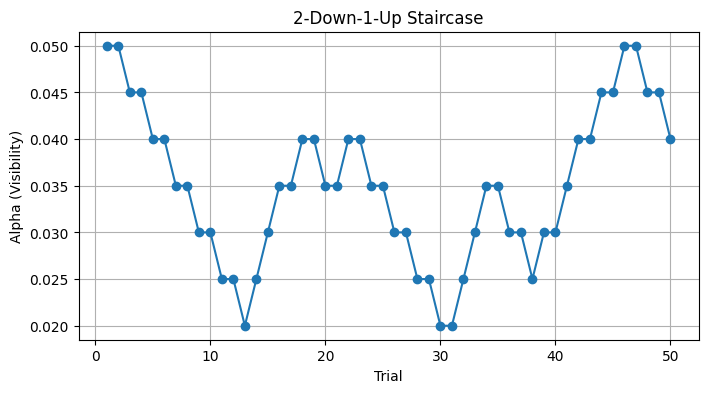

In [12]:
def Norm(image):
    return 2 * image - 1

# Visual Setup
win = visual.Window(size=(512, 512), color=-1, units="pix", fullscr=False)
stim = visual.ImageStim(win, size=(512, 512), units="pix")

# Parameters
letters = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L']
noises = ['#', '@', '$', '%', '&']
soa = 0.05
noise_gap = 0.05
step_size = 0.005
n_trials = 50
correct_counter = 0
data = []

# Instructions Screen
instruction = visual.TextStim(win, text="Press SPACE to begin the task.\nType the letter you see as fast and accurately as you can.", color=1.0, height=24)
instruction.draw()
win.flip()

# Wait for spacebar to begin
event.waitKeys(keyList=['space'])
win.flip()


# Trial Loop
for trial in range(n_trials):
    if 'escape' in event.getKeys():
        print("Experiment aborted by user.")
        break

    fixation = visual.TextStim(win, text="+", color=1.0, height=48)
    fixation.draw()
    win.flip()
    core.wait(0.5)
    true_letter = random.choice(letters)
    stim.image = np.flipud(Norm(LetterImage(true_letter)))
    stim.draw()
    win.flip()
    core.wait(soa)
    for i in range(3):
        noise = random.choice(noises)
        stim.image = np.flipud(Norm(LetterImage(noise)))
        stim.draw()
        win.flip()
        core.wait(noise_gap)
        
    win.flip()
    
    keys = event.waitKeys(keyList=[l.lower() for l in letters] + ['escape'])
    if 'escape' in keys:
        print("Experiment aborted by user.")
        break

    response = keys[0].upper()
    correct = response == true_letter
    data.append({"trial": trial+1, "letter": true_letter, "response": response,
                 "correct": correct, "soa": soa})
    if correct:
        correct_counter += 1
        if correct_counter == 2:
            soa = max(0, soa - step_size)
            correct_counter = 0
    else:
        soa = min(1.0, soa + step_size)
        correct_counter = 0

# Cleanup 
win.close()

# ---------- Plot ----------
soas = [d["soa"] for d in data]
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_trials + 1), soas, marker='o')
plt.xlabel("Trial")
plt.ylabel("Alpha (Visibility)")
plt.title("2-Down-1-Up Staircase")
plt.grid(True)
plt.show()

# Optional: save data
import pandas as pd
df = pd.DataFrame(data)
df.to_csv("Results.csv", index=False)